In [3]:
from copy import deepcopy
import numpy as np
import plotly.graph_objects as go

class DisplayFigs:
    def _rgb_to_hex(rgb):
        '''Convert colors to Plotly hex color strings'''
        rgb255 = (rgb * 255).astype(int)
        return ['rgb({},{},{})'.format(r, g, b) for r, g, b in rgb255]


    def display_plotly_orig_and_clouds(orig_fig, cloud_figs: set):
        # Extract metadata for origin figure
        verts_fig = np.asarray(orig_fig.vertices)
        tris_fig = np.asarray(orig_fig.triangles)
        orig_colors = np.asarray(orig_fig.vertex_colors) if orig_fig.has_vertex_colors() else np.full(verts_fig.shape, [128/255, 26/255, 107/255])

        # Exrtact metadata for cloud figures
        cloud_figs_points = []
        cloud_figs_colors_hex = []
        for cloud_fig in cloud_figs:
            cloud_figs_points.append(np.asarray(cloud_fig.points))

            fig_colors = np.asarray(cloud_fig.colors) if cloud_fig.has_colors() else np.tile([0, 0, 1], (len(cloud_fig.points), 1))
        
            cloud_figs_colors_hex.append(DisplayFigs._rgb_to_hex(fig_colors))

        orig_trace = go.Mesh3d(
            x=verts_fig[:, 0], y=verts_fig[:, 1], z=verts_fig[:, 2],
            i=tris_fig[:, 0], j=tris_fig[:, 1], k=tris_fig[:, 2],
            vertexcolor=orig_colors,
            opacity=0.8,
            showlegend=False,
            name=''
        )

        cloud_figs_trace = []
        for points, colors in zip(cloud_figs_points, cloud_figs_colors_hex):
            cloud_figs_trace.append(go.Scatter3d(
                x=points[:, 0], y=points[:, 1], z=points[:, 2],
                mode='markers',
                marker=dict(size=2, color=colors),
                showlegend=False,
                name=''
            ))

        merged_trace = [orig_trace,] + cloud_figs_trace

        fig = go.Figure(data=merged_trace)

        fig.update_layout(
            showlegend=False,
            scene=dict(
                xaxis=dict(visible=False),
                yaxis=dict(visible=False),
                zaxis=dict(visible=False),
                aspectmode='data'
            ),
            margin=dict(t=0, l=0, r=0, b=0)
        )

        fig.show(config={'displayModeBar': False})


    def display_plotly_origs(orig_figs: set):
        traces = []
        for orig_fig in orig_figs:
            vertices = np.asarray(orig_fig.vertices)
            triangles = np.asarray(orig_fig.triangles)
            color = np.asarray(orig_fig.vertex_colors) if orig_fig.has_vertex_colors() else np.full(vertices.shape, [128/255, 26/255, 107/255])

            traces.append(
                go.Mesh3d(
                    x=vertices[:, 0], y=vertices[:, 1], z=vertices[:, 2],
                    i=triangles[:, 0], j=triangles[:, 1], k=triangles[:, 2],
                    vertexcolor=color,
                    opacity=0.8,
                    showlegend=False,
                    name=''
                )
            )

        fig = go.Figure(data=traces)

        fig.update_layout(
            showlegend=False,
            scene=dict(
                xaxis=dict(visible=False),
                yaxis=dict(visible=False),
                zaxis=dict(visible=False),
                aspectmode='data'
            ),
            margin=dict(t=0, l=0, r=0, b=0)
        )

        fig.show(config={'displayModeBar': False})


    def display_plotly_clouds(cloud_figs: set, non_in_line=False, offset_step=3.0):
        cloud_figs_trace = []
        for i, cloud_fig in enumerate(cloud_figs):
            points = np.asarray(cloud_fig.points)
            color = DisplayFigs._rgb_to_hex(
                np.asarray(cloud_fig.colors) if cloud_fig.has_colors() else np.tile([1.0, 0.75, 0.0], (len(cloud_fig.points), 1))
            )

            offset_points = deepcopy(points)
            if non_in_line:
                offset_points[:, 0] += i * offset_step

            cloud_figs_trace.append(go.Scatter3d(
                x=offset_points[:, 0], y=offset_points[:, 1], z=offset_points[:, 2],
                mode='markers',
                marker=dict(size=2, color=color),
                showlegend=False,
                name=''
            ))

        fig = go.Figure(data=cloud_figs_trace)

        fig.update_layout(
            showlegend=False,
            scene=dict(
                xaxis=dict(visible=False),
                yaxis=dict(visible=False),
                zaxis=dict(visible=False),
                aspectmode='data'
            ),
            margin=dict(t=0, l=0, r=0, b=0)
        )

        fig.show(config={'displayModeBar': False})

# Реализация классификатора 3D объектов по извлеченным признакам методами SVM, Random Forest, KNN. Оценка точности методов

### Загрузка данных

In [4]:
from pathlib import Path
import os

import open3d as o3d
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
# !python 4_setup_dataset.py --root dataset
# !python 4_generate_primitives.py --split train
# !python 4_generate_primitives.py --split val
# !python 4_generate_primitives.py --split test

In [60]:
sphere_path = 'dataset/test/sphere/s_0003.ply'
cyl_path = 'dataset/test/cylinder/y_0003.ply'
cube_path = 'dataset/test/cube/c_0003.ply'

In [65]:
pcd_raw  = o3d.io.read_point_cloud(cube_path)
# o3d.visualization.draw_geometries([pcd_raw])

# DisplayFigs.display_plotly_clouds((pcd_raw, ))
pcd_raw

PointCloud with 6777 points.

In [4]:
DATA_ROOT = Path("dataset")
SPLITS = ["train", "val", "test"]
CLASSES = ["sphere", "cube", "cylinder"]
CLS_TO_IDX = {c: i for i, c in enumerate(CLASSES)}

# Параметры препроцессинга для признаков

VOXEL_SIZE = 0.01 # 0.005
RADIUS_NORMAL = 3.0 * VOXEL_SIZE # попробовать 2
MAX_NN_NORMAL = 30

# FPFH
RADIUS_FPFH = 5.0 * VOXEL_SIZE
MAX_NN_FPFH = 100

# ISS keypoints
ISS_SALIENT_RADIUS = 6.0 * VOXEL_SIZE
ISS_NON_MAX_RADIUS = 4.0 * VOXEL_SIZE
ISS_GAMMA_21 = 0.975
ISS_GAMMA_32 = 0.975
ISS_MIN_NEIGHBORS = 5

In [18]:
def load_point_cloud(path: Path) -> o3d.geometry.PointCloud:
    pcd = o3d.io.read_point_cloud(str(path))
    return pcd

In [ ]:
def quick_prepare(pcd: o3d.geometry.PointCloud,
                  voxel_size: float = None,
                  radius_normal: float = RADIUS_NORMAL,
                  max_nn_normal: int = MAX_NN_NORMAL) -> o3d.geometry.PointCloud:

    if voxel_size:
        pcd = pcd.voxel_down_sample(voxel_size)
        
    pcd.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=max_nn_normal)
    )
    pcd.orient_normals_consistent_tangent_plane(max_nn_normal)
    return pcd

### FPFH: вычисление и агрегация

1. Построение локальной системы координат:

   $$
   u = n_p, \quad v = \frac{u \times (q - p)}{\|u \times (q - p)\|}, \quad w = u \times v
   $$

   * $p$ — текущая точка.
   * $q$ — соседняя точка.
   * $n_p, n_q$ — нормали в точках $p$ и $q$.
   * $u, v, w$ — ортонормированный базис.
   * $\times$ — векторное произведение.

2. Три угловых признака:

   $$
   \alpha = v \cdot n_q, \quad 
   \phi = u \cdot \frac{q-p}{\|q-p\|}, \quad
   \theta = \arctan2(w \cdot n_q, u \cdot n_q)
   $$

   * $\alpha$ — насколько нормаль соседа лежит в направлении $v$.
   * $\phi$ — проекция направления от $p$ к $q$ на ось $u$.
   * $\theta$ — угол ориентации нормали $n_q$ в плоскости $(u, w)$.

3. Гистограммы $\alpha, \phi, \theta$ - SPFH.

4. Взвешенное усреднение SPFH соседей - FPFH.

---

### **FPFH** — это локальный 3D-дескриптор.
Он описывает **форму поверхности вокруг каждой точки** облака — в виде набора чисел (гистограммы).

1. Главная идея

    Вокруг каждой точки берём **локальную окрестность** (радиусом r).
    Смотрим, как расположены **нормали соседей** относительно **нормали центральной точки**.
    То есть — не просто где соседи находятся, а **под какими углами** и **в каких направлениях** относительно локальной поверхности.

Как строится признак (в 3 шага)
1. SPF (Simplified Point Feature) — локальное отношение двух точек

    Берём пару точек (центральная p и соседняя q), знаем их нормали n_p и n_q.
    Считаем три угла (или компоненты):

    * **α**— угол между вектором p-q и нормалью p,

    * **φ** — угол между нормалью p и нормалью q,

    * **θ** — угол между нормалью q и направлением p-q.

    Эти три значения описывают, как соседняя точка определена на поверхности относительно центральной точки.

2. PFH (Point Feature Histogram) — медленный вариант

    Раньше PFH считался для всех пар соседей в окрестности, что очень дорого (O(k²)).
    Для каждого из трёх параметров строили гистограмму — получали объёмную 3D-гистограмму признаков формы.

3. **FPFH** (Fast PFH) — ускоренный вариант

    Вместо всех пар соседей, FPFH делает так:

    * Сначала считает SPF только между **центральной** точкой и каждым **соседом** (O(k));

    * Потом **усредняет** результаты соседей, **взвешивая по расстоянию**.

4. Что в итоге получаем

    Для каждой точки облака — **вектор признаков из 33 элементов.**

    В нём зашифровано, какая форма вокруг точки:

    * ровная, изогнутая, острая, вогнутая и т.д.

    * и как эта форма ориентирована относительно соседей.

    Обычно усредняют все векторы точек одного объекта и получают один компактный дескриптор (например, 66 чисел: mean + std).

### На 1 объекте

In [20]:
pcd = load_point_cloud(sphere_path)
prepared = quick_prepare(pcd, VOXEL_SIZE, RADIUS_NORMAL, MAX_NN_NORMAL)
fpfh = o3d.pipelines.registration.compute_fpfh_feature(
        prepared,
        o3d.geometry.KDTreeSearchParamHybrid(radius=RADIUS_FPFH, max_nn=MAX_NN_FPFH)
    )
o3d.visualization.draw_geometries([prepared], point_show_normal=True)

2025-11-04 08:29:50.502 Python[13408:466077] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.


In [21]:
mu = fpfh.data.mean(axis=1)
sd = fpfh.data.std(axis=1)
fpfh_vector = np.concatenate([mu, sd], axis=0).astype(np.float32)

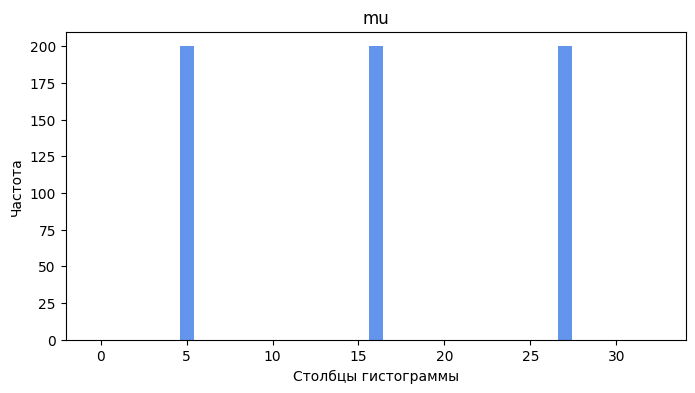

In [22]:
plt.figure(figsize=(8,4))
plt.bar(range(33), mu, color='cornflowerblue')
plt.title("mu")
plt.xlabel("Столбцы гистограммы")
plt.ylabel("Частота")
plt.show()


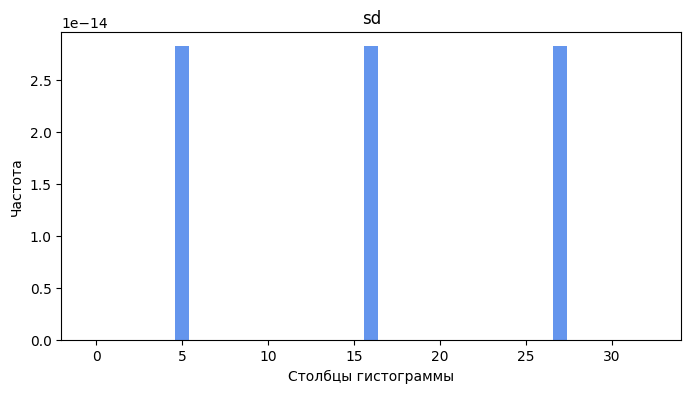

In [23]:
plt.figure(figsize=(8,4))
plt.bar(range(33), sd, color='cornflowerblue')
plt.title("sd")
plt.xlabel("Столбцы гистограммы")
plt.ylabel("Частота")
plt.show()

### FPFH = 3 гистограммы по 11 столбцов:

* **α**— угол между вектором p-q и нормалью p,

* **φ** — угол между нормалью p и нормалью q,

* **θ** — угол между нормалью q и направлением p-q.

In [24]:
def compute_fpfh_vector(pcd: o3d.geometry.PointCloud,
                        radius_feature: float = RADIUS_FPFH,
                        max_nn: int = MAX_NN_FPFH) -> np.ndarray:
    """Возвращает вектор признаков объекта: concat(mean, std) FPFH."""
    fpfh = o3d.pipelines.registration.compute_fpfh_feature(
        pcd,
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=max_nn)
    ).data  # shape: (33, n_points)

    mu = fpfh.mean(axis=1)
    sd = fpfh.std(axis=1)
    return np.concatenate([mu, sd], axis=0).astype(np.float32)  # 66-мерный вектор

### 3) Обход датасета и извлечение признаков

In [ ]:
def iter_split_files(root: Path, split: str):
    base = root / split
    for cls in CLASSES:
        cls_dir = base / cls
        if not cls_dir.exists():
            continue
        for fn in os.listdir(cls_dir):
            if fn.lower().endswith((".ply", ".pcd", ".xyz")):
                yield cls, (cls_dir / fn)

def extract_vector_for_object(path: Path) -> np.ndarray:
    pcd = load_point_cloud(path)
    pcd = quick_prepare(pcd, VOXEL_SIZE, RADIUS_NORMAL, MAX_NN_NORMAL)

    return compute_fpfh_vector(pcd, RADIUS_FPFH, MAX_NN_FPFH)

def build_split_matrix(root: Path, split: str):
    X, y, ids = [], [], []
    for cls, path in tqdm(
        list(iter_split_files(root, split)), desc=f"{split}", unit="obj"
        ):
        try:
            vec = extract_vector_for_object(path)
            X.append(vec)
            y.append(CLS_TO_IDX[cls])
            ids.append(str(path))
        except Exception as e:
            print(f"[WARN] {path}: {e}")
    if len(X) == 0:
        return np.empty((0,)), np.empty((0,)), []
    X = np.stack(X)
    y = np.array(y, dtype=np.int64)
    return X, y, ids

In [26]:
def train_and_eval(Xtr, ytr, Xval, yval, Xte, yte, model, label: str):
    model.fit(Xtr, ytr)
    for split_name, Xs, ys in [("val", Xval, yval), ("test", Xte, yte)]:
        yp = model.predict(Xs)
        acc = accuracy_score(ys, yp)
        print(f"[{label}] {split_name} accuracy: {acc:.4f}")
        print(classification_report(ys, yp, target_names=CLASSES, digits=4))
        print("Confusion:\n", confusion_matrix(ys, yp))
        print("-"*60)

In [27]:
feature_sets = {}
for split in SPLITS:
    X, y, ids = build_split_matrix(DATA_ROOT, split)
    feature_sets[split] = {"X": X, "y": y, "ids": ids}
    print(split, X.shape, np.bincount(y, minlength=len(CLASSES)))

train:   0%|          | 0/154 [00:00<?, ?obj/s]

train: 100%|██████████| 154/154 [2:37:14<00:00, 61.26s/obj]    


train (154, 66) [54 50 50]


val: 100%|██████████| 150/150 [18:13<00:00,  7.29s/obj]


val (150, 66) [50 50 50]


test: 100%|██████████| 150/150 [31:16<00:00, 12.51s/obj]   

test (150, 66) [50 50 50]


In [198]:
ytr

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [28]:
Xtr = feature_sets["train"]["X"]
ytr = feature_sets["train"]["y"]
Xval = feature_sets["val"]["X"]
yval = feature_sets["val"]["y"]
Xte  = feature_sets["test"]["X"]
yte  = feature_sets["test"]["y"]

# KNN
knn = make_pipeline(
    StandardScaler(with_mean=True, with_std=True),
    KNeighborsClassifier(n_neighbors=7, metric="euclidean", weights="distance")
)
train_and_eval(Xtr, ytr, Xval, yval, Xte, yte, knn, f"KNN")

# SVM (RBF)
svm = make_pipeline(
    StandardScaler(with_mean=True, with_std=True),
    SVC(kernel="rbf", C=10.0, gamma="scale")
)
train_and_eval(Xtr, ytr, Xval, yval, Xte, yte, svm, f"SVM-RBF")

[KNN] val accuracy: 1.0000
              precision    recall  f1-score   support

      sphere     1.0000    1.0000    1.0000        50
        cube     1.0000    1.0000    1.0000        50
    cylinder     1.0000    1.0000    1.0000        50

    accuracy                         1.0000       150
   macro avg     1.0000    1.0000    1.0000       150
weighted avg     1.0000    1.0000    1.0000       150

Confusion:
 [[50  0  0]
 [ 0 50  0]
 [ 0  0 50]]
------------------------------------------------------------
[KNN] test accuracy: 0.9733
              precision    recall  f1-score   support

      sphere     1.0000    1.0000    1.0000        50
        cube     0.9600    0.9600    0.9600        50
    cylinder     0.9600    0.9600    0.9600        50

    accuracy                         0.9733       150
   macro avg     0.9733    0.9733    0.9733       150
weighted avg     0.9733    0.9733    0.9733       150

Confusion:
 [[50  0  0]
 [ 0 48  2]
 [ 0  2 48]]
------------------------

# ISS (Intrinsic Shape Signatures):

## 1. Строгое определение и математическая основа

**Цель ISS.** Выбрать небольшое подмножество **ключевых точек** $keypoints$ — локально «информативные» места (углы, вершины, пересечения поверхностей), где геометрия меняется по всем трём направлениям. Эти точки устойчиво воспроизводимы и подходят для последующего описания (например, FPFH) и сопоставления.

**Локальная статистика.** Для каждой точки $p$ рассматривается окрестность $\mathcal{N}(p)$ радиусом $r_\text{sal}$ (salient_radius). Строится матрица рассеяния (ковариации) координат соседей:
$$
\mu_p=\frac{1}{|\mathcal{N}(p)|}\sum_{q\in \mathcal{N}(p)}q,\qquad

\Sigma(p)=\frac{1}{|\mathcal{N}(p)|}\sum_{q\in \mathcal{N}(p)}(q-\mu_p)(q-\mu_p)^\top .
$$

**Собственные значения** $\lambda_1\ge \lambda_2\ge \lambda_3\ge 0$ и собственные векторы ${v_1,v_2,v_3}$ получаем из разложения $\Sigma(p),v_i=\lambda_i v_i$.

Геометрический смысл:

* $\lambda_1$ — сила разброса вдоль главного направления,
* $\lambda_2$ — второе направление,
* $\lambda_3$ — остаточный разброс (насколько 3D-структура выходит из плоскости).

**Критерий анизотропии (фильтр кандидатов).** 

Точка считается **геометрически выразительной**, если **отношения собственных значений малы**:
$$
\frac{\lambda_2}{\lambda_1}<\gamma_{21}\quad\text{и}\quad \frac{\lambda_3}{\lambda_2}<\gamma_{32},
$$
где $\gamma_{21},\gamma_{32}\in(0,1)$ — пороги (обычно 0.8–0.97).

Малая $\lambda_2/\lambda_1$ означает, что первое направление сильно доминирует над вторым; малая $\lambda_3/\lambda_2$ — что второе доминирует над третьим. Совместно это описывает «острый» трёхмерный угол/узел, а не плоскость или чистое ребро.

**Мера значимости (saliency).** В качестве отклика берут
$$
\rho(p)=\lambda_3(p),
$$
поскольку в плоской области $\lambda_3\approx 0$, на ребре $\lambda_3$ мало, а в настоящем 3D-узле $\lambda_3$ ощутимо положительно.

**Подавление немаксимумов (NMS).**

Среди прошедших пороги точек выбираются **локальные максимумы** $\rho$ в радиусе $r_\text{nms}$ (non_max_radius). Это избавляет от близко расположенных дублей.

**Параметры:**

* `salient_radius`: радиус статистики (чем больше — тем более «глобальный» контекст).
* `non_max_radius`: радиус подавления немаксимумов.
* `gamma_21`, `gamma_32`: пороги анизотропии (<1); ниже — строже, ключевых точек меньше.
* `min_neighbors`: минимально допустимое число соседей (чтобы $\Sigma$ не вырождалась).

---

Представьте шар соседей вокруг точки. Мы измеряем, **как они расположены в 3D**.
* Если соседи лежат почти в **плоскости**: два больших направления и одно маленькое $\Rightarrow \lambda_1\approx\lambda_2\gg\lambda_3$.

    Это **не** ключевая точка (обычная грань).

* Если соседи тянутся вдоль **линии (ребра)**: одно большое направление, два маленьких $\Rightarrow \lambda_1\gg\lambda_2\approx\lambda_3$.
    
    Это тоже **не** цель ISS.

* Если соседи распределены **во всех трёх направлениях** (угол/вершина/узел): $\lambda_1\gg\lambda_2\gg\lambda_3$, и при этом $\lambda_3$ заметно выше нуля.

    Вот такие точки ISS и выбирает.

Коротко: **ISS находит места 3D-структуры**, где локальная геометрия меняется не только в плоскости или вдоль линии, а **сразу по трём осям**.

---

## 3. Ожидаемая картина на простых формах

* **Сфера:** локально гладкая и изотропная поверхность — **ключевых точек почти нет** (в идеальной синтетике — ноль).
* **Куб:** ключевые точки концентрируются на **вершинах**; на ровных гранях — нет; на чистых рёбрах — редко проходят оба порога.
* **Цилиндр:** ключевые точки на **кромках торцов**; на боковой поверхности — обычно отсутствуют (локально почти плоскость).

**Интерпретация**: чем больше ключевых точек, тем больше у объекта «структурных особенностей» (острые детали, пересечения, отверстия, узлы).

---

In [29]:
P = np.array([
    [0.00, 0.00, 0.00],
    [1.00, 0.00, 0.00],
    [0.00, 1.00, 0.00],
    [1.00, 1.00, 0.00],
    [0.50, 0.50, 0.90],  # выпуклость вверх
    [2.00, 0.00, 0.00],
    [2.00, 1.00, 0.10],
    [0.00, 2.00, 0.00],
    [1.00, 2.00, 0.05],
    [0.50, 0.50, -0.20], # вниз
], dtype=float)

In [ ]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(P)
colors = np.tile(np.array([[0.2, 0.6, 1.0]]), (P.shape[0], 1))
colors[4] = [1.0, 0.2, 0.2]   # точка 4 — красная
colors[9] = [0.0, 1.0, 0.0]   # точка 9 — зелёная
pcd.colors = o3d.utility.Vector3dVector(colors)

axes = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5) # X (красная), Y (зелёная), Z (синяя).

DisplayFigs.display_plotly_orig_and_clouds(axes,(pcd,))
# o3d.visualization.draw_geometries([pcd, axes])

In [39]:
# Берём окрестность вокруг точки p[4]
p = P[4]
r = 1.1
dists = np.linalg.norm(P - p, axis=1)
neigh_idx = np.where(dists <= r)[0]
N = P[neigh_idx]

print("Расстояние до каждой точки:\n", dists)
print("Соседи точки p4:", neigh_idx)
print(N)

Расстояние до каждой точки:
 [1.14455231 1.14455231 1.14455231 1.14455231 0.         1.81934054
 1.77200451 1.81934054 1.79513231 1.1       ]
Соседи точки p4: [4 9]
[[ 0.5  0.5  0.9]
 [ 0.5  0.5 -0.2]]


In [40]:
mu = N.mean(axis=0)
cov_matrix  = ((N - mu).T @ (N - mu)) / len(N)
print("\nСреднее (μ):\n", mu)
print("\nКовариационная матрица:\n", cov_matrix )


Среднее (μ):
 [0.5  0.5  0.35]

Ковариационная матрица:
 [[0.     0.     0.    ]
 [0.     0.     0.    ]
 [0.     0.     0.3025]]


#### Ковариационная матрица

$\Sigma = \begin{bmatrix}
\text{var(X)} & \text{cov(X,Y)} & \text{cov(X,Z)} \\
\text{cov(X,Y)} & \text{var(Y)} & \text{cov(Y,Z)} \\
\text{cov(X,Z)} & \text{cov(Y,Z)} & \text{var(Z)}
\end{bmatrix}$

**Что означает каждый элемент**

1. **Диагональные элементы** (var(X), var(Y), var(Z)):
* Показывают **дисперсию** (разброс) точек вдоль соответствующей оси
* Чем больше число, тем сильнее разброс точек
* Это как "толщина" облака точек вдоль каждой оси

2. **Недиагональные элементы** (cov(X,Y), cov(X,Z), cov(Y,Z)):
* Показывают **взаимосвязь** между осями
* Могут быть:
  * **Положительными** — точки растут вместе (если X растет, Y тоже растет)
  * **Отрицательными** — точки растут в противоположных направлениях (X растет, Y падает)
  * **Нулевыми** — нет связи между осями

**Разбор матрицы**

$\Sigma = \begin{bmatrix}
0 & 0 & 0 \\
0 & 0 & 0 \\
0 & 0 & 0.3025
\end{bmatrix}$

**Значения означают:**

* **var(X) = 0** — нет разброса точек по оси X
* **var(Y) = 0** — нет разброса точек по оси Y
* **var(Z) = 0.3025** — есть небольшой разброс по оси Z
* Все **ковариации = 0** — оси не связаны между собой

**Практический смысл**

Такая матрица говорит нам, что:
* Точки практически не двигаются по осям X и Y
* Есть небольшое движение только по оси Z
* Нет никакой связи между осями

#### Собственные векторы и значения

In [41]:
w, v = np.linalg.eigh(cov_matrix)
w = w[::-1]  # по убыванию
v = v[:, ::-1]

lambda1 = w[0]
lambda2 = w[1]
lambda3 = w[2]

print("\nСобственные значения (λ):", w)
print(f"\nОтношения λ₂/λ₁ = {lambda1/lambda2:.3f}, λ₃/λ₂ = {lambda3/lambda2:.3f}")


Собственные значения (λ): [0.3025 0.     0.    ]

Отношения λ₂/λ₁ = inf, λ₃/λ₂ = nan


/var/folders/22/40809ksx1nn76c07qmtrv6sw0000gn/T/ipykernel_13408/1243371112.py:10: RuntimeWarning:

divide by zero encountered in scalar divide

/var/folders/22/40809ksx1nn76c07qmtrv6sw0000gn/T/ipykernel_13408/1243371112.py:10: RuntimeWarning:

invalid value encountered in scalar divide



### Вычисление ISS

In [42]:
def compute_iss_keypoints(pcd: o3d.geometry.PointCloud,
                          salient_radius: float = ISS_SALIENT_RADIUS,
                          non_max_radius: float = ISS_NON_MAX_RADIUS,
                          gamma_21: float = ISS_GAMMA_21,
                          gamma_32: float = ISS_GAMMA_32,
                          min_neighbors: int = ISS_MIN_NEIGHBORS) -> o3d.geometry.PointCloud:
    kp = o3d.geometry.keypoint.compute_iss_keypoints(
        pcd,
        salient_radius=salient_radius,
        non_max_radius=non_max_radius,
        gamma_21=gamma_21,
        gamma_32=gamma_32,
        min_neighbors=min_neighbors
    )
    return kp

In [43]:
sphere = quick_prepare(load_point_cloud('dataset/test/sphere/s_0002.ply'))
cube = quick_prepare(load_point_cloud('dataset/test/cube/c_0002.ply'))
cyl = quick_prepare(load_point_cloud('dataset/test/cylinder/y_0002.ply'))

skp = compute_iss_keypoints(sphere)
ckp = compute_iss_keypoints(cube)
cykp = compute_iss_keypoints(cyl)

In [44]:
skp

PointCloud with 258 points.

In [45]:
# o3d.visualization.draw_geometries([skp])
# o3d.visualization.draw_geometries([ckp])
# o3d.visualization.draw_geometries([cykp])

DisplayFigs.display_plotly_clouds((skp,))
DisplayFigs.display_plotly_clouds((ckp,))
DisplayFigs.display_plotly_clouds((cykp,))

In [46]:
fpfh = o3d.pipelines.registration.compute_fpfh_feature(
        skp,
        o3d.geometry.KDTreeSearchParamHybrid(radius=RADIUS_FPFH, max_nn=MAX_NN_FPFH)
    )
# o3d.visualization.draw_geometries([skp], point_show_normal=True)

In [47]:
mu = fpfh.data.mean(axis=1)
sd = fpfh.data.std(axis=1)
fpfh_vector = np.concatenate([mu, sd], axis=0).astype(np.float32)

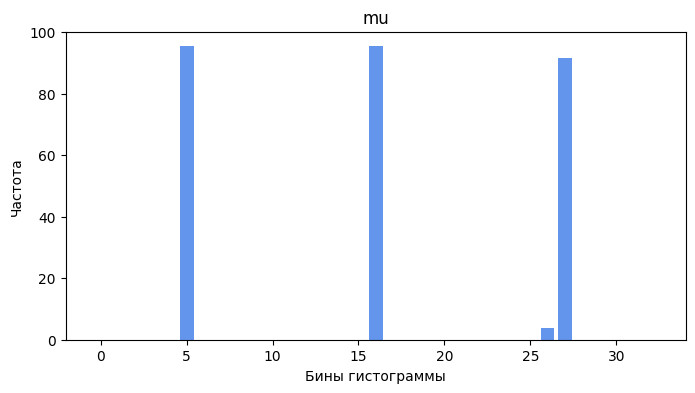

In [48]:
plt.figure(figsize=(8,4))
plt.bar(range(33), mu, color='cornflowerblue')
plt.title("mu")
plt.xlabel("Бины гистограммы")
plt.ylabel("Частота")
plt.show()

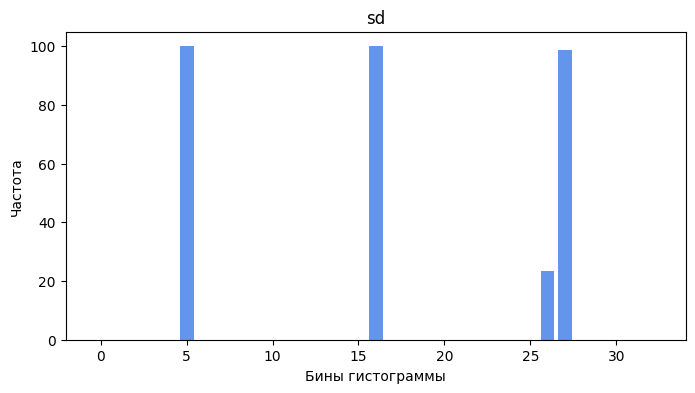

In [49]:
plt.figure(figsize=(8,4))
plt.bar(range(33), sd, color='cornflowerblue')
plt.title("sd")
plt.xlabel("Бины гистограммы")
plt.ylabel("Частота")
plt.show()

In [50]:
def iter_split_files(root: Path, split: str):
    base = root / split
    for cls in CLASSES:
        cls_dir = base / cls
        if not cls_dir.exists():
            continue
        for fn in os.listdir(cls_dir):
            if fn.lower().endswith((".ply", ".pcd", ".xyz")):
                yield cls, (cls_dir / fn)

def extract_vector_for_object(path: Path) -> np.ndarray:
    """descriptor: 'fpfh' | 'shot' | 'iss_fpfh'."""
    pcd = load_point_cloud(path)
    pcd = quick_prepare(pcd, VOXEL_SIZE, RADIUS_NORMAL, MAX_NN_NORMAL)
    kp = compute_iss_keypoints(pcd)
    return compute_fpfh_vector(kp, RADIUS_FPFH, MAX_NN_FPFH)
    # return compute_iss_fpfh_vector(pcd)

def build_split_matrix(root: Path, split: str):
    X, y, ids = [], [], []
    for cls, path in tqdm(list(iter_split_files(root, split)),
                          desc=f"{split}", unit="obj"):
        try:
            vec = extract_vector_for_object(path)
            X.append(vec)
            y.append(CLS_TO_IDX[cls])
            ids.append(str(path))
        except Exception as e:
            print(f"[WARN] {path}: {e}")
    if len(X) == 0:
        return np.empty((0,)), np.empty((0,)), []
    X = np.stack(X)
    y = np.array(y, dtype=np.int64)
    return X, y, ids

In [208]:
type(Xtr)

numpy.ndarray

In [ ]:
feature_sets = {}
for split in SPLITS:
    X, y, ids = build_split_matrix(DATA_ROOT, split)
    feature_sets[split] = {"X": X, "y": y, "ids": ids}
    print(split, X.shape, np.bincount(y, minlength=len(CLASSES)))
    
Xtr = feature_sets["train"]["X"]
ytr = feature_sets["train"]["y"]
Xval = feature_sets["val"]["X"]
yval = feature_sets["val"]["y"]
Xte  = feature_sets["test"]["X"]
yte  = feature_sets["test"]["y"]

In [ ]:
# KNN
knn = make_pipeline(
    StandardScaler(with_mean=True, with_std=True),
    KNeighborsClassifier(n_neighbors=7, metric="euclidean", weights="distance")
)
train_and_eval(Xtr, ytr, Xval, yval, Xte, yte, knn, f"KNN")

# SVM (RBF)
svm = make_pipeline(
    StandardScaler(with_mean=True, with_std=True),
    SVC(kernel="rbf", C=10.0, gamma="scale")
)
train_and_eval(Xtr, ytr, Xval, yval, Xte, yte, svm, f"SVM-RBF")

[KNN] val accuracy: 1.0000
              precision    recall  f1-score   support

      sphere     1.0000    1.0000    1.0000         3
        cube     1.0000    1.0000    1.0000         3
    cylinder     1.0000    1.0000    1.0000         3

    accuracy                         1.0000         9
   macro avg     1.0000    1.0000    1.0000         9
weighted avg     1.0000    1.0000    1.0000         9

Confusion:
 [[3 0 0]
 [0 3 0]
 [0 0 3]]
------------------------------------------------------------
[KNN] test accuracy: 1.0000
              precision    recall  f1-score   support

      sphere     1.0000    1.0000    1.0000         3
        cube     1.0000    1.0000    1.0000         3
    cylinder     1.0000    1.0000    1.0000         3

    accuracy                         1.0000         9
   macro avg     1.0000    1.0000    1.0000         9
weighted avg     1.0000    1.0000    1.0000         9

Confusion:
 [[3 0 0]
 [0 3 0]
 [0 0 3]]
------------------------------------------

## Классификация

1. Сгенерировать набор данных из геометрических примитивов(5 классов)

2. Добавить:
   * Гауссовский шум(`sigma_rel = 0.01`)
   * случайные выбросы(`p_out = 0.05`, `bbox_expand = 1.2`)

3. Выполнить классификацию

4. Критерии оценки

f1-score

| Уровень качества        | f1-score               |
| ----------------------- | ---------------------- |
| **Отлично**             | ( >= 0.95 )            |
| **Хорошо**              | ( 0.85 – 0.094 )       |
| **Удовлетворительно**   | ( 0.75 – 0.84 )        |
| **Неудовлетворительно** | ( < 0.75 )             |

### Helpfull

In [19]:
# Параметры препроцессинга для признаков

EX_COUNT = 1_000
POINTS_COUNT = 5_000
SIGMA_REL = 0.01
P_OUT = 0.05
BBOX_EXPAND = 1.2

RADIUS_NORMAL = 2.0 * SIGMA_REL # попробовать 2
MAX_NN_NORMAL = 30

# FPFH
RADIUS_FPFH = 5.0 * SIGMA_REL
MAX_NN_FPFH = 100

# ISS keypoints
ISS_SALIENT_RADIUS = 6.0 * SIGMA_REL
ISS_NON_MAX_RADIUS = 4.0 * SIGMA_REL
ISS_GAMMA_21 = 0.9
ISS_GAMMA_32 = 0.9
ISS_MIN_NEIGHBORS = 5

In [20]:
def quick_prepare(pcd: o3d.geometry.PointCloud,
                  voxel_size: float = None,
                  radius_normal: float = RADIUS_NORMAL,
                  max_nn_normal: int = MAX_NN_NORMAL) -> o3d.geometry.PointCloud:

    if voxel_size:
        pcd = pcd.voxel_down_sample(voxel_size)
        
    pcd.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=max_nn_normal)
    )
    pcd.orient_normals_consistent_tangent_plane(max_nn_normal)
    return pcd


def compute_iss_keypoints(pcd: o3d.geometry.PointCloud,
                          salient_radius: float = ISS_SALIENT_RADIUS,
                          non_max_radius: float = ISS_NON_MAX_RADIUS,
                          gamma_21: float = ISS_GAMMA_21,
                          gamma_32: float = ISS_GAMMA_32,
                          min_neighbors: int = ISS_MIN_NEIGHBORS) -> o3d.geometry.PointCloud:
    kp = o3d.geometry.keypoint.compute_iss_keypoints(
        pcd,
        salient_radius=salient_radius,
        non_max_radius=non_max_radius,
        gamma_21=gamma_21,
        gamma_32=gamma_32,
        min_neighbors=min_neighbors
    )
    return kp

def compute_fpfh_vector(pcd: o3d.geometry.PointCloud,
                        radius_feature: float = RADIUS_FPFH,
                        max_nn: int = MAX_NN_FPFH) -> np.ndarray:
    """Возвращает вектор признаков объекта: concat(mean, std) FPFH."""
    fpfh = o3d.pipelines.registration.compute_fpfh_feature(
        pcd,
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=max_nn)
    ).data  # shape: (33, n_points)

    mu = fpfh.mean(axis=1)
    sd = fpfh.std(axis=1)
    return np.concatenate([mu, sd], axis=0).astype(np.float32)  # 66-мерный вектор

def train_and_eval(Xtr, ytr, Xval, yval, Xte, yte, model, label: str, target_names):
    model.fit(Xtr, ytr)
    for split_name, Xs, ys in [("val", Xval, yval), ("test", Xte, yte)]:
        yp = model.predict(Xs)
        acc = accuracy_score(ys, yp)
        print(f"[{label}] {split_name} accuracy: {acc:.4f}")
        print(classification_report(ys, yp, target_names=target_names, digits=4))
        print("Confusion:\n", confusion_matrix(ys, yp))
        print("-"*60)

### 1. Generate geometric primitives

In [21]:
# 1. Generate geometric primitives

import random

class PrimitivesGenerator:
    def _cube(cls, e: float):
        return o3d.geometry.TriangleMesh.create_box(width=e, height=e, depth=e)

    def _sphere(cls, r: float, resolution: int = 40):
        return o3d.geometry.TriangleMesh.create_sphere(radius=r, resolution=resolution)

    def _cylinder(cls, r: float, h: float, resolution: int = 64, split: int = 4):
        return o3d.geometry.TriangleMesh.create_cylinder(
            radius=r, height=h, resolution=resolution, split=split
        )

    def _cone(cls, r: float, h: float, resolution: int=20):
        return o3d.geometry.TriangleMesh.create_cone(radius=r, height=h, resolution=resolution)

    def _torus(cls, tr_r: float, tb_r: float, radial_resolution: float=30, tubular_resolution: float=20):
        return o3d.geometry.TriangleMesh.create_torus(
            torus_radius=tr_r,
            tube_radius=tb_r,
            radial_resolution=radial_resolution,
            tubular_resolution=tubular_resolution
        )

    def generate_primitives(cls, cloud_points=POINTS_COUNT, ex_count=EX_COUNT):
        primitives = {
            'cube': {
                'fnc': cls._cube, 
                'kwargs': {'e': random.uniform(0.4, 1.2)}, 
                'data': []
            },
            'sphere': {
                'fnc': cls._sphere, 
                'kwargs': {'r': random.uniform(0.3, 0.9)}, 
                'data': []
            },
            'cylinder': {
                'fnc': cls._cylinder,
                'kwargs': {'r': random.uniform(0.25, 0.7), 'h': random.uniform(0.5, 1.5)},
                'data': []
            },
            'cone': {
                'fnc': cls._cone, 
                'kwargs': {'r': random.uniform(0.25, 0.7), 'h': random.uniform(0.5, 1.5)}, 
                'data': []
            },
            'torus': {
                'fnc': cls._torus, 
                'kwargs': {'tr_r': random.uniform(1.0, 1.5), 'tb_r': random.uniform(0.3, 0.5)}, 
                'data': []
            }
        }

        for k in primitives.keys():
            print(f'Generate {k} primitives')
            for _ in tqdm(range(ex_count)):
                current_img = {}
                current_img['fig'] = primitives[k]['fnc'](**primitives[k]['kwargs'])
                current_img['origin_pcd'] = current_img['fig'].sample_points_uniformly(cloud_points)

                primitives[k]['data'].append(current_img)
                # ['fig'].paint_uniform_color([random.random(), random.random(), random.random()])
        
        return primitives

In [22]:
primitives = PrimitivesGenerator().generate_primitives()

Generate cube primitives


100%|██████████| 1000/1000 [00:01<00:00, 644.58it/s]


Generate sphere primitives


100%|██████████| 1000/1000 [00:05<00:00, 179.08it/s]


Generate cylinder primitives


100%|██████████| 1000/1000 [00:04<00:00, 247.47it/s]


Generate cone primitives


100%|██████████| 1000/1000 [00:02<00:00, 395.55it/s]


Generate torus primitives


100%|██████████| 1000/1000 [00:02<00:00, 398.21it/s]


In [23]:
random_figs_pcd = tuple([
    fig['data'][random.randint(0, EX_COUNT)]['origin_pcd'] for fig in primitives.values()
])


DisplayFigs.display_plotly_clouds(random_figs_pcd, non_in_line=True)

In [24]:
random_figs_pcd[0]

PointCloud with 5000 points.

### 2. Add noise 

In [25]:
from copy import deepcopy

def add_noise(primitives, sigma_rel=SIGMA_REL, p_out=P_OUT, bbox_expand=BBOX_EXPAND):
    for k in primitives.keys():
        print(f'Generate {k} dirty pcd')
        for i in tqdm(range(len(primitives[k]['data']))):
            primitives[k]['data'][i]['pcd'] = deepcopy(primitives[k]['data'][i]['origin_pcd'])

            # gausian
            noise = np.random.normal(scale=sigma_rel, size=np.asanyarray(primitives[k]['data'][i]['pcd'].points).shape)
            primitives[k]['data'][i]['pcd'].points = o3d.utility.Vector3dVector(np.asarray(primitives[k]['data'][i]['pcd'].points) + noise)

            # emission
            num_outliers = int(len(primitives[k]['data'][i]['pcd'].points) * p_out)
            pcd_max = primitives[k]['data'][i]['pcd'].get_max_bound()
            pcd_min = primitives[k]['data'][i]['pcd'].get_min_bound()
            bbox = pcd_min - pcd_min
            outliers = np.random.uniform(
                low=(pcd_min - bbox * (bbox_expand - 1)/2),
                high=(pcd_max + bbox * (bbox_expand - 1)/2),
                size=(num_outliers, 3),
            )
            all_outlines = np.vstack((np.asarray(primitives[k]['data'][i]['pcd'].points), outliers))
            primitives[k]['data'][i]['pcd'].points = o3d.utility.Vector3dVector(all_outlines)
            
            # original_colors = np.asarray(primitives[k]['data'][i]['origin_pcd'].colors)
            # outlier_color = np.array([[0.5, 0.5, 0.5]] * num_outliers)  # gray
            # combined_colors = np.vstack([original_colors, outlier_color])
            # primitives[k]['data'][i]['pcd'].colors = o3d.utility.Vector3dVector(combined_colors)



In [26]:
add_noise(primitives)

Generate cube dirty pcd


100%|██████████| 1000/1000 [00:01<00:00, 501.67it/s]


Generate sphere dirty pcd


100%|██████████| 1000/1000 [00:02<00:00, 452.53it/s]


Generate cylinder dirty pcd


100%|██████████| 1000/1000 [00:01<00:00, 576.31it/s]


Generate cone dirty pcd


100%|██████████| 1000/1000 [00:01<00:00, 596.79it/s]


Generate torus dirty pcd


100%|██████████| 1000/1000 [00:01<00:00, 564.94it/s]


In [27]:
random_figs_pcd = tuple([
    fig['data'][random.randint(0, EX_COUNT)]['pcd'] for fig in primitives.values()
])


DisplayFigs.display_plotly_clouds(random_figs_pcd, non_in_line=True)

### 3. ISS and FPFH

In [28]:
for k in primitives.keys():
    print(f'Generate {k} iss pcd')
    for i in tqdm(range(len(primitives[k]['data']))):
        primitives[k]['data'][i]['iss_pcd'] = compute_iss_keypoints(
            quick_prepare(primitives[k]['data'][i]['pcd'])
        )
        primitives[k]['data'][i]['fpfh_pcd'] = compute_fpfh_vector(primitives[k]['data'][i]['iss_pcd'])

Generate cube iss pcd


100%|██████████| 1000/1000 [04:50<00:00,  3.45it/s]


Generate sphere iss pcd


100%|██████████| 1000/1000 [04:27<00:00,  3.74it/s]


Generate cylinder iss pcd


100%|██████████| 1000/1000 [04:25<00:00,  3.76it/s]


Generate cone iss pcd


100%|██████████| 1000/1000 [04:37<00:00,  3.60it/s]


Generate torus iss pcd


100%|██████████| 1000/1000 [04:21<00:00,  3.83it/s]


In [ ]:
random_figs_pcd = tuple([
    fig['data'][random.randint(0, EX_COUNT)]['iss_pcd'] for fig in primitives.values()
])



DisplayFigs.display_plotly_clouds(random_figs_pcd, non_in_line=True)

### KNN and evaluation

In [36]:
def create_learning_datasets(primitives):
    X_train, X_val, X_test = [], [], []
    y_train, y_val, y_test = [], [], []

    for i, k in enumerate(primitives.keys()):
        current_iss_pcd = [np.asarray(el['fpfh_pcd']) for el in primitives[k]['data']]

        X_train.extend(current_iss_pcd[:800]) 
        X_val.extend(current_iss_pcd[800:900])
        X_test.extend(current_iss_pcd[900:])

        y_train.extend([i for _ in range(800)]) 
        y_val.extend([i for _ in range(100)])
        y_test.extend([i for _ in range(100)])

    # return X_train, X_val, X_test, y_train, y_val, y_test
    return np.array(X_train), np.array(X_val), np.array(X_test), np.array(y_train), np.array(y_val), np.array(y_test)

In [37]:
X_train, X_val, X_test, y_train, y_val, y_test = create_learning_datasets(primitives)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((4000, 66), (500, 66), (500, 66), (4000,), (500,), (500,))

In [ ]:
# SVM (RBF)

svm = make_pipeline(
    StandardScaler(with_mean=True, with_std=True),
    SVC(kernel="rbf", C=10.0, gamma="scale")
)
train_and_eval(X_train, y_train, X_val, y_val, X_test, y_test, svm, f"SVM-RBF", list(primitives.keys()))

[SVM-RBF] val accuracy: 0.9240
              precision    recall  f1-score   support

        cube     0.9200    0.9200    0.9200       100
      sphere     0.8824    0.9000    0.8911       100
    cylinder     0.9000    0.9000    0.9000       100
        cone     0.9184    0.9000    0.9091       100
       torus     1.0000    1.0000    1.0000       100

    accuracy                         0.9240       500
   macro avg     0.9241    0.9240    0.9240       500
weighted avg     0.9241    0.9240    0.9240       500

Confusion:
 [[ 92   0   8   0   0]
 [  0  90   2   8   0]
 [  8   2  90   0   0]
 [  0  10   0  90   0]
 [  0   0   0   0 100]]
------------------------------------------------------------
[SVM-RBF] test accuracy: 0.9040
              precision    recall  f1-score   support

        cube     0.9062    0.8700    0.8878       100
      sphere     0.8627    0.8800    0.8713       100
    cylinder     0.8641    0.8900    0.8768       100
        cone     0.8889    0.8800    0.884

In [ ]:
# Finall scores on 5_000 samples
'''
[SVM-RBF] val accuracy: 0.9240
              precision    recall  f1-score   support

        cube     0.9200    0.9200    0.9200       100
      sphere     0.8824    0.9000    0.8911       100
    cylinder     0.9000    0.9000    0.9000       100
        cone     0.9184    0.9000    0.9091       100
       torus     1.0000    1.0000    1.0000       100

    accuracy                         0.9240       500
   macro avg     0.9241    0.9240    0.9240       500
weighted avg     0.9241    0.9240    0.9240       500

Confusion:
 [[ 92   0   8   0   0]
 [  0  90   2   8   0]
 [  8   2  90   0   0]
 [  0  10   0  90   0]
 [  0   0   0   0 100]]
------------------------------------------------------------
[SVM-RBF] test accuracy: 0.9040
              precision    recall  f1-score   support

        cube     0.9062    0.8700    0.8878       100
      sphere     0.8627    0.8800    0.8713       100
    cylinder     0.8641    0.8900    0.8768       100
        cone     0.8889    0.8800    0.8844       100
       torus     1.0000    1.0000    1.0000       100

    accuracy                         0.9040       500
   macro avg     0.9044    0.9040    0.9041       500
weighted avg     0.9044    0.9040    0.9041       500

Confusion:
 [[ 87   0  13   0   0]
 [  0  88   1  11   0]
 [  9   2  89   0   0]
 [  0  12   0  88   0]
 [  0   0   0   0 100]]
------------------------------------------------------------
'''